In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt 
import ipynb
from ipynb.fs.full.Preprocessing import *   # you need "pip install ipynb" first
from utilities import *


In [2]:
males= read_imgs(dir_path='data/Male/Male')

In [3]:
females= read_imgs(dir_path='data/Female/Female')

In [4]:
'''
Calcultes the skew angle of the image sent from the verticies calculated
using the min enclosing box.


params:
------
image          np.array  assumed to be an image of written text

return:
-------
skewd_angle    float    the angle for the text is assumed to be in a logical range  +ve , -ve and 0 
                        but not infinity since no one writes vertically.
                        The angle is just *100 due to the small values the skewed_angle is
------

NOTE:
using the angle retured from the minAreaRect is not suitable for our sitiuation.
'''

def calculate_skew(image):
    
    gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    gray=cv2.bitwise_not(gray)
    Gblur=cv2.blur(gray,(5,5))
    thresh=cv2.threshold(Gblur,0,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    # getting the minimum enclosed rectangle 
    coords = np.column_stack(np.where(thresh > 0))
    angle = cv2.minAreaRect(coords)
    box = cv2.boxPoints(angle)
    box=np.int0(box)
    #calculating the angle using the verticies of the minimum enclosing rectangle 
    #by simply getting the verticies with leat y and calclating the slope using these 2 verticies
    x=np.array([box[0][0],box[1][0],box[2][0],box[3][0]])
    y=np.array([box[0][1],box[1][1],box[2][1],box[3][1]]) 

    res = sorted(range(len(y)), key = lambda sub: y[sub])[:2]

    x1=x[res[0]]
    x2=x[res[1]]
    y1=y[res[0]]
    y2=y[res[1]]

    skewed_angle=0
    if (x1<x2):
        skewed_angle=(y2-y1)/(x2-x1)
    else: skewed_angle=(y1-y2)/(x1-x2)

    return skewed_angle*100


#### In the next 4 cells , we can observe the males and females skewness angle calculated on the entire paragraph.
#### Obviously, by the eye,  it didnot bring a very differentiating result

In [5]:
males_angles=[]
for male in males:
    angle=calculate_skew(male)
    males_angles.append(angle)

In [6]:
females_angles=[]
for female in females:
    angle=calculate_skew(female)
    females_angles.append(angle)

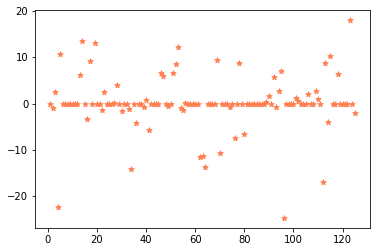

In [7]:
x=list(range(1,len(males)+1))
plt.scatter(x,y=males_angles,label="males skew angle",marker='*',s=30 , c='coral')


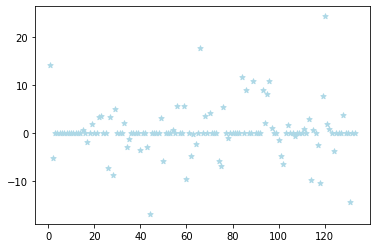

In [8]:
x=list(range(1,len(females)+1))
plt.scatter(x,y=females_angles,label="females skew angle",marker='*',s=30 , c='lightblue')

#### Another approach is to get the average skewness of the lines which we will handle it in the next few cells

In [9]:
'''
Extract The start and end of each sequence of successive true values in the array.

params:
------
arr          np.array  boolean array containing false and true values

return:
-------
lines_start  np.array  array containing the start index of each sequence of true values.
lines_end    np.array  array containing the end index of each sequence of true values.

example:
-------

arr = np.array([True True False True True True False True False])
lines_start, lines_end = extract_successive_trues(arr)

>> lines_start
array([0 3 7])

>> lines_end
array([2 6 8])

'''
def extract_successive_trues(horiz_proj):
    processing_line = False
    lines_start = []
    lines_end = []

    for i in range(len(horiz_proj)):
        if(processing_line == True):
            if(horiz_proj[i] == False):
                lines_end.append(i)
                processing_line = False
        else:
            if(horiz_proj[i] == True):
                processing_line = True
                lines_start.append(i)
                
    # if the last element in arr was true
    if (len(lines_end) == len(lines_start) - 1):
        # Set the end of the last line as the last index of the array
        lines_end.append(len(horiz_proj))
        
    return lines_start, lines_end

In [10]:
'''
Extract lines from a handwritten image.

params:
-------
img                   np.arrray()   Image to extract lines from.
margin_top            float         How many pixels above the extracted line to consider.
margin_bottom         float         How many pixels below the extracted line to consider.
avg_thickness_perc    float         The percentage of the average thickness below which to discard a line.
verbose               boolean       If true show a visualization of the lines extracted. By default: False.

returns:
-------
lines                 list          List of images, each image holds a line extracted from the original image. Each image is an np.array.
'''
def extract_lines(img, margin_top=30, margin_bottom=15, avg_thickness_perc = 0.5, verbose=False):
    
    # Sum across the horizontal axis i.e across the text lines
    horiz_proj = np.sum(img, axis=1)
    
    # Calculating the threshold between having text (a line) or having white spacing between lines
    avg = np.average(horiz_proj)
    margin = (np.max(horiz_proj)-avg)/3
    thres = avg + margin
    
    if (verbose):
        # Rotate image by 90 degrees
        img_90 = rotate(img, 90, resize=True)
        plt.imshow(img_90, cmap='gray')

        # Plot the lines' summation values
        plt.plot(range(0,len(horiz_proj)),horiz_proj) 

        plt.axhline(y=thres, color='r', linestyle='-')
        plt.show()
    
    # Extract Lines start index and end index
    lines_start, lines_end = extract_successive_trues(horiz_proj < thres)
    
    lines = []
    lines_thickness = []

    # Discard noisy lines - lines with thickness smaller than 10 pixels
    for i in range(len(lines_start)):
        line_thickness = lines_end[i] - lines_start[i]
        if (line_thickness > 10):
            lines_thickness.append(line_thickness)  

    # Estimate the average thickness of filtered lines (for Lines > 10 pixels)
    lines_thickness = np.array([lines_thickness])
    avg_thickness = np.average(lines_thickness)
    
    lines_thickness = []
    # Extract the lines from the image
    for i in range(len(lines_start)):
        # Add margines to the lines starting and ending indices
        line_top = lines_start[i] - margin_top
        line_bottom = lines_end[i] + margin_bottom

        line_thickness = lines_end[i] - lines_start[i]
        # Discard noisy lines - lines with thickness smaller than 0.5 of the average thicknesses (default)
        if (line_thickness > avg_thickness_perc*avg_thickness):
            lines_thickness.append(line_thickness)
            lines.append(img[line_top:line_bottom, :])
            if (verbose):
                plt.imshow(img[line_top:line_bottom, :])
                plt.show()

    if (verbose):
        print("lines' thickness array: ", lines_thickness[0])
        print('avg thickness of this paper: ', avg_thickness)
        print('discard lines thiner than: ', avg_thickness*avg_thickness_perc)
        print("final lines' thickness array: ", lines_thickness)

    return lines

In [11]:
'''
calculates the skew angle of the whole paragraph by extracting lines first and 
using calculate skew on each valid line.
since there could be lines cropped that is invalid so we filter the irrelevant ones.

params:
-------
img                   np.arrray()   Image to calculate its average skewness angle.

returns:
-------
angle                 float          Average skewness angle. If -100 means the image wasnot valid to calcualte on it the angle.
'''
def calculte_average_line_skewness(img):
    img=extract_textarea(threshold_image(img))
    lines=extract_lines(img)
    angle=0
    valid_lines=0
    for line in lines:
        if(np.count_nonzero(line)!=0):
            # we need to return the grey line to rgb simce calculate_skew by iteself needs to convert to gray scale
            line=cv2.cvtColor(line,cv2.COLOR_GRAY2RGB)
            angle+=calculate_skew(line)
            valid_lines+=1
    if(valid_lines!=0):
        angle=angle/valid_lines
        return angle
    else: return -100   #since returning 0 or -1 in our case could occur for valid cases but -100 skewness seems impossible
 

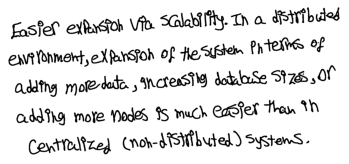

Average line skewness = 2.764092568037878
Paragraph Skewness = -10.702113156100886


In [12]:
# This cell just shows how the calcuation of the average line skewness 
# and the entire paragraph skewness is different.
image=cv2.imread('data/Male/Male/M2.jpg')
show_image(extract_textarea(threshold_image(image)))
avg=calculte_average_line_skewness(image)
print("Average line skewness = "+str(avg))
print("Paragraph Skewness = "+str(calculate_skew(image)))

In [13]:
males_avg_angles=[]
for male in males:
    angle=calculte_average_line_skewness(male)
    if(angle!=-100):
        males_avg_angles.append(angle)

c:\Users\halah\Python\Python39\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\Users\halah\Python\Python39\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


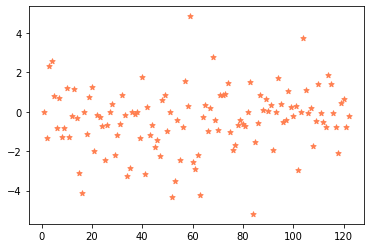

In [14]:
x=list(range(1,len(males_avg_angles)+1))
plt.scatter(x,y=males_avg_angles,label="males skew angle",marker='*',s=30 , c='coral')

In [15]:
females_avg_angles=[]
for female in females:
    angle=calculte_average_line_skewness(female)
    if(angle!=-100):
        females_avg_angles.append(angle)

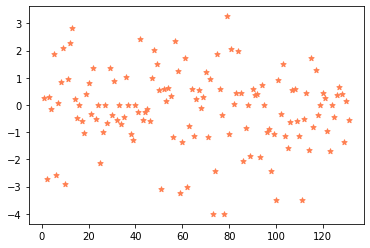

In [16]:
x=list(range(1,len(females_avg_angles)+1))
plt.scatter(x,y=females_avg_angles,label="males skew angle",marker='*',s=30 , c='coral')

In [28]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import metrics

X = np.concatenate((males_avg_angles, females_avg_angles), axis=0)
y = np.concatenate((np.zeros(len(males_avg_angles)),np.ones(len(females_avg_angles))),axis=0) 

X_train, X_test, y_train, y_test = train_test_split(X.reshape((-1,1)), y, test_size=0.33, random_state=42)
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.5357142857142857
